# Задание 1

In [35]:
# Импортируем требуемые библиотеки
import pandahouse as ph
import pandas as pd
import requests
import numpy as np
from urllib.parse import urlencode
import seaborn as sns
import scipy.stats as ss
from scipy.stats import chi2_contingency
from scipy.stats import bootstrap
import matplotlib.pyplot as plt
import datetime

In [22]:
def get_yandex_file(public_key):
    '''Функция загрузки файл с Яндекс.Диска. На вход функции подается ссылка на файл, 
    в резульате получаем скачанный файл в формате csv'''

    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return (download_url)

In [23]:
# Загружаем файлы и сохраняем их
groups = pd.read_csv(get_yandex_file('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep = ';')
groups_add = pd.read_csv(get_yandex_file('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'))
students = pd.read_csv(get_yandex_file('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'))
checks = pd.read_csv(get_yandex_file('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep = ';')


# 1. Подготовка данных

Для всех датасетов проверяю корректность типов данных, наличие дублей, пустых строк

In [5]:
groups.dtypes

id      int64
grp    object
dtype: object

In [6]:
groups.isna().sum()

id     0
grp    0
dtype: int64

In [7]:
duplicateRows = groups[groups.duplicated()]
duplicateRows

,id,grp


In [9]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [28]:
groups_add.shape

(92, 2)

In [10]:
groups_add.isna().sum()

id     0
grp    0
dtype: int64

In [11]:
duplicateRows = groups_add[groups_add.duplicated()]
duplicateRows

,id,grp


In [12]:
students.dtypes

student_id    int64
dtype: object

In [13]:
students.isna().sum()

student_id    0
dtype: int64

In [14]:
duplicateRows = students[students.duplicated()]
duplicateRows

,student_id


In [17]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [18]:
checks.isna().sum()

student_id    0
rev           0
dtype: int64

In [19]:
duplicateRows = checks[checks.duplicated()]
duplicateRows

,student_id,rev


Объединяю все данные в один датафрейм. Сначала соединяю 2 файла с информацией о группах пользователей.

In [23]:
groups_full = pd.concat([groups,groups_add])
groups_full                      

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
87,200247820,B
88,201032527,B
89,201067612,B
90,201067653,B


Проверяю не задублировались ли данные:

In [5]:
groups_full.id.nunique()

74576

Кол-во уникальных id и число строк совпадает, значит дублей id нет.

Добавляю в итоговую таблицу информацию, кто из пользователей был активен. Для этого сначала в таблицу с активными пользователями добавляю столбец "active" со значением "yes" и переименуем student_id в id для простоты объединения:

In [5]:
students['active'] = "yes"
students = students.rename(columns = {'student_id': 'id'})

Затем делаю left join с итоговой таблицей с группами пользователей

In [8]:
groups_full = groups_full.merge(students, how = 'left', on = 'id')
groups_full

,id,grp,active
0,1489,B,NaN
1,1627,A,yes
2,1768,B,NaN
3,1783,B,NaN
4,1794,A,NaN
...,...,...,...
74571,200247820,B,NaN
74572,201032527,B,NaN
74573,201067612,B,NaN
74574,201067653,B,NaN


В столбце active меняю пустые значения на No

In [9]:
groups_full['active'] = groups_full.active.fillna('no')
groups_full

,id,grp,active
0,1489,B,no
1,1627,A,yes
2,1768,B,no
3,1783,B,no
4,1794,A,no
...,...,...,...
74571,200247820,B,no
74572,201032527,B,no
74573,201067612,B,no
74574,201067653,B,no


Добавляю информацию об оплатах. Произвожу left join с таблицей checks и пустые значения заполняю нулями.

In [10]:
checks = checks.rename(columns={'student_id':'id'})
groups_full = groups_full.merge(checks, how = 'left', on = 'id')
groups_full['rev'] = groups_full.rev.fillna(0)

In [10]:
groups_full

,id,grp,active,rev
0,1489,B,no,0.0
1,1627,A,yes,990.0
2,1768,B,no,0.0
3,1783,B,no,0.0
4,1794,A,no,0.0
...,...,...,...,...
74571,200247820,B,no,0.0
74572,201032527,B,no,0.0
74573,201067612,B,no,0.0
74574,201067653,B,no,0.0


In [11]:
checks.id.nunique()

541

Произведу проверку, были ли среди пользователей те, которые произвели оплату, не заходя на сайт (т.е. неактивные). 

In [11]:
groups_full_mistake = groups_full.query('active == "no" & rev > 0')
groups_full_mistake

,id,grp,active,rev
39,3185,B,no,690.0
121,25973,B,no,690.0
125,26280,B,no,690.0
223,100645,B,no,630.0
254,102534,B,no,580.0
...,...,...,...,...
72452,5291900,B,no,199.0
72753,5331842,B,no,290.0
73632,5486319,B,no,199.0
74049,5562806,B,no,398.0


In [12]:
err = groups_full.query('id == 264473')
err

,id,grp,active,rev
3779,264473,B,yes,1900.0001


Вижу, что в таблице 140 строк с такой ошибкой. Необходимо сообщить разработчикам,что требуется проверка, откуда появляется данная ошибка, т.к. неактивных оплат не может быть.

# 2. Выбор и расчет метрик

Т.к. новое изменение связано с оплатой, метрики также должны быть связаны с этапом оплаты продукта.
Для проверки гипотезы выбираю 3 метрики:
    1. CR - конверсия активного пользователя в покупку. Выбираю именно конверсию активного пользователя, т.к. те, кто не заходил на платформу, даже не видели новой функции и не могут участововать в эксперименте. CR=Кол-во активных пользователей, совершивших покупку/общее кол-во активных пользователей
    2. ARPAU - средний чек активного пользователя. Также беру только активных пользователей, т.к. те, кто не заходил на платформу, даже не видели новой функции. ARPAU=Общая сумма прибыли от активных пользователей/кол-во активных пользователей
    3. ARPPU - средний чек активного платящего пользователя.Беру только платящих пользователей, т.к. те, кто не оплачивал, мог не увидеть новой механики. ARPPU=Общая сумма прибыли от активных пользователей/кол-во платящих активных пользователей

## 2.1 Проверяем гипотезу, что вырос CR (конверсия активного пользователя в покупку) после внедрения новой механики оплаты на сайте

Добавляю новый столбец buy, который будет =1, если покупка совершена и 0, если покупки не было. Т.е. 1- если пользоатель сконвертировался и 0, если не конвертировался.


In [16]:
active_students = groups_full[groups_full.active == "yes"]
active_students['buy'] = np.where(active_students['rev'] == 0, 0, 1)
active_students


/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,grp,active,rev,buy
1,1627,A,yes,990.0,1
10,2085,B,yes,0.0,0
12,2215,B,yes,0.0,0
43,3391,A,yes,0.0,0
45,3401,B,yes,0.0,0
...,...,...,...,...,...
74543,5760471,B,yes,0.0,0
74545,5777081,B,yes,0.0,0
74558,5870856,A,yes,0.0,0
74561,5945085,B,yes,0.0,0


Считаю CR для каждой группы

In [17]:
CR = active_students.groupby('grp', as_index=False).agg({'id': 'count', 'buy': 'sum'})
CR['cr'] = CR.buy / CR.id
CR

,grp,id,buy,cr
0,A,1538,78,0.050715
1,B,6803,314,0.046156


Получается, что CR целевой группы В снизился по сравнению с контрольной группой А. проверю, является ли изменение статистически значимым. Для проверки можно использовать метод bootstrap, т.к. он позволяет проверить определенную метрику.

Нулевая гипотеза H0 — ничего не поменялось, изменение CR является случайным результатом. Наша альтернативная гипотеза H1 — изменение значимо, коэффициент пользователей в целевой группе вырос.

Делю на группы. Т.к. нам для бутстрапа нужно посчитать CR, а CR считается как сумма сконвертировавшихся пользователей / на общее кол-во, что совпадает с с формулой среднего по столбцу buy, подойдет функция np.mean

In [18]:
CR_A = active_students.query('grp == "A"')

In [19]:
bootstrap((CR_A.buy, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.03966189856957087, high=0.06176853055916775), standard_error=0.005569983562897098)

In [20]:
CR_B = active_students.query('grp == "B"')

In [22]:
bootstrap((CR_B.buy, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=0.041158312509187125, high=0.05115390268998971), standard_error=0.0025158724524758543)

Для группы А доверительный интервал получился [0.0397 - 0.0618], для группы B доверительный интервал [0.0412 - 0.0512]. У доверительных интервалов есть пересечение, это означает, что статистически значимого отличия в полученных оценках параметра нет. Нулевая гипотеза не может быть отклонена.

Перепроверим результат при помощи функции ХИ квадрат.  У нас 2 категориальные переменные, поэтому будем использовать критерий ХИ квадрат. H0 : нулевая гипотеза утврждает, что сконвертировался пользователь или нет не зависит от его принадлежности к какой-то группе и отличия случайны. H1 : гипотеза утврждает, что сконвертировался пользователь или нет зависит от его принадлежности к какой-то группе и различие CR в группах является статистически значимым

In [20]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(active_students.buy, active_students.grp))

In [21]:
stat, p

(0.48480826522557896, 0.48625240457231045)

## p-value>0.05, следовательно принимаем Н0, сконвертировался пользователь или нет не зависит от его принадлежности к тестовой или контрольной группе. Следовательно новое изменение на конверсию статистически значимо не влияет.

## 2.2 Проверяем гипотезу, что вырос ARPAU (средний чек активного пользователя) после внедрения новой механики оплаты на сайте

Сначала посмотрю на графике, как распределяется средний чек в двух группах:

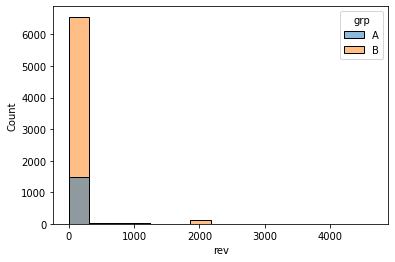

In [23]:
sns.histplot(active_students, x = "rev", hue = "grp")

Распределения не являются нормальными. Посчитаю средний чек для каждой группы:

In [36]:
students_A = active_students.query('grp == "A"')
ARPAU_A = students_A.rev.sum() / students_A.shape[0]
print(ARPAU_A)
students_A

47.34720416124838


,id,grp,active,rev,buy
1,1627,A,yes,990.0,1
43,3391,A,yes,0.0,0
331,109623,A,yes,0.0,0
614,133678,A,yes,0.0,0
1002,175944,A,yes,0.0,0
...,...,...,...,...,...
74416,5668989,A,yes,0.0,0
74469,5690284,A,yes,0.0,0
74523,5723133,A,yes,0.0,0
74528,5729371,A,yes,0.0,0


In [45]:
students_B = active_students.query('grp == "B"')
ARPAU_B = students_B.rev.sum() / students_B.shape[0]
print(ARPAU_B)

58.058798103777754


Средний чек активного пользователя в целевой группе выше среднего чека в контрольной группе. 
Т.к. нам необходимо сравнивать средние значения, а распределения не являются нормальными,  для проверки гипотезы я буду использовать метод bootstrap. U-критерий Манна-Уитни не подойдет, т.к. он не сравнивает средние значения.

С помощью метода Bootstrap проверим следующие гипотезы: Нулевая гипотеза H0 — ничего не поменялось, изменение ARPAU является случайным результатом. Наша альтернативная гипотеза H1 — изменение значимо, средний чек пользователей в целевой группе вырос.

Т.к. нам для бутстрапа нужно посчитать средний чек, подойдет функция np.mean

In [43]:
bootstrap((students_A.rev, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=34.95772370037015, high=63.995425703279366), standard_error=7.32887255505104)

In [46]:
bootstrap((students_B.rev, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=50.80062742091181, high=65.98287255132209), standard_error=3.8199865838051275)

Для группы А доверительный интервал получился [34.96 - 66.00], для группы B доверительный интервал [50.80 - 65.98]. У доверительных интервалов есть пересечение, это означает, что статистически значимого отличия в полученных оценках параметра нет. Нулевая гипотеза не может быть отклонена.

## Доверительные интервалы пересекаются, следовательно не отклоняем Н0. По даннному критерию статистических отличий нет. Новая механика оплаты не влияет на средний чек активного пользователя.

## 2.3 Проверяем гипотезу, что вырос ARPPU (средний чек активного платящего пользователя) после внедрения новой механики оплаты на сайте

In [47]:
paying_students = active_students.query('rev > 0')

Сначала посмотрю на графике, как распределяется средний чек в двух группах:

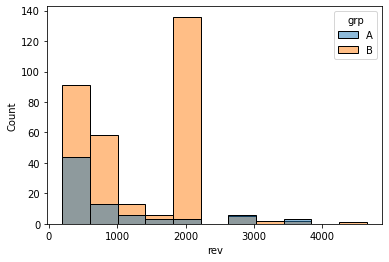

In [48]:
sns.histplot(paying_students, x = "rev", hue = "grp")

Распределения не являются нормальными. Посчитаю средний чек для каждой группы:

In [50]:
students_A = paying_students.query('grp == "A"')
ARPPU_A = students_A.rev.sum() / students_A.shape[0]
print(ARPPU_A)

933.5897435897435


In [51]:
students_B = paying_students.query('grp == "B"')
ARPPU_B = students_B.rev.sum() / students_B.shape[0]
print(ARPPU_B)

1257.8789920382164


Средний чек активного пользователя в целевой группе выше среднего чека в контрольной группе. Т.к. нам необходимо сравнивать средние значения, а распределения не являются нормальными, для проверки гипотезы я буду использовать метод bootstrap. U-критерий Манна-Уитни не подойдет, т.к. он не сравнивает средние значения.

С помощью метода Bootstrap проверим следующие гипотезы: Нулевая гипотеза H0 — ничего не поменялось, изменение ARPPU является случайным результатом. Наша альтернативная гипотеза H1 — изменение значимо, средний чек пользователей в целевой группе вырос.

In [52]:
bootstrap((students_A.rev, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=752.5091352652178, high=1171.2121741598828), standard_error=104.4885892274619)

In [53]:
bootstrap((students_B.rev, ), np.mean)

BootstrapResult(confidence_interval=ConfidenceInterval(low=1171.2213834456045, high=1350.2045249621472), standard_error=45.316793796020846)

Для группы А доверительный интервал получился [752.51 - 1171.21], для группы B доверительный интервал [1171.22 - 1350.20]. У доверительных интервалов нет пересечения, это означает, что имеется статистически значимое отличие в полученных оценках параметра. Нулевая гипотеза может быть отклонена.

## У доверительных интервалов нет пересечения, значит мы отклоняем гипотезу Н0. Следовательно различия имеются и являются статистически значимыми. Новая механика оплаты влияет на средний чек платящих пользователей, в целевой группе он увеличился на 324 рубля (27%), что является значимым изменением. 

# 3. Заключение. В ходе эксперимента было проверено влияние новой механики оплаты на конверсию в покупку, на средний чек всех активных пользователей и платящих активных пользователей контрольной и целевой группы. Положительное статистически значимое влияние было подтверждено только на средний чек платящих пользователей. Новую механику оплаты стоит запустить для всех пользователей, т.к. она значимо увеличивает прибыль от платящих пользователей. После запуска новой функции рекомендуется следить за показателем CR  - конверсия активного пользователя в покупку т.к. было замечено негативное отклонение в целевой группе. Оно не являлось статистически значимым, но желательно проверить на других данных, чтобы его не пропустить. 

# Задание 2

## 2.1 Очень усердные ученики.

In [6]:
# Объявляем параметры подключения к clickhouse
connection = dict(database = 'default',
                  host = 'https://clickhouse.lab.karpov.courses',
                  user = 'student',
      password = 'dpo_python_2020')

In [7]:
# пишем запрос, и получаем данные из clickhouse в pandas dataframe
# 1 вариант.Универсальный запрос для любой таблицы:
# Нахожу последний месяц с помощью WITH:
query = """
WITH 
    (SELECT MAX(toStartOfMonth(timest)) FROM default.peas) AS last_month

SELECT
count(st_id) AS diligent_students
FROM( 
    SELECT
    st_id,
    toStartOfMonth(timest) AS start_of_month,
    count(timest) as peas_number
    FROM default.peas
    WHERE correct = TRUE AND start_of_month = last_month
    GROUP BY st_id, start_of_month
    )
WHERE peas_number >= 20 
"""
diligent_students = ph.read_clickhouse(query, connection = connection)
diligent_students

,diligent_students
0,136


In [34]:
# пишем запрос, и получаем данные из clickhouse в pandas dataframe
# 2 вариант. В предложенной таблице данные только за 2 дня одного месяца, 
# поэтому для данной таблицы дату в запросе можно не учитывать. Оптимальный запрос будет:
query = """
SELECT
count(st_id) AS diligent_students
FROM(    
    SELECT
    st_id,
    count(timest) as peas_number
    FROM default.peas
    WHERE correct = TRUE
    GROUP BY st_id)
WHERE peas_number >= 20  
"""
diligent_students = ph.read_clickhouse(query, connection = connection)
diligent_students

,diligent_students
0,136


## 2.1 Ответ: 136 очень усердных учеников

## 2.2 Оптимизация воронки

In [9]:
# пишем запрос, и получаем данные из clickhouse в pandas dataframe
query = """
-- Считаю требуемые метрики по группам пользователей:
SELECT
test_grp,
sum(total_money) / count(users) AS ARPU,
sum(total_money) / sum(activity) AS ARPAU,
sum(payment) / count(users) AS CR,
sum(payment) / sum(activity) AS CR_active,
sum(math_payment) / sum(math_activity) AS CR_math
FROM(
-- Объединеннная таблица из трёх таблиц: students, peas и final_project_check,группирую по пользователям и группам
        SELECT 
            C.st_id AS users,
            C.test_grp AS test_grp,
            AVG(C.correct) AS correct_sum, -- беру среднее значение, т.к. при объединении таблиц строки задублировались 
            AVG(C.math_active) AS math_active, -- беру среднее значение, т.к. при объединении таблиц строки задублировались
            SUM(D.money) AS total_money,
            SUM(CASE 
                WHEN D.subject = 'Math' THEN 1 
                ELSE 0 
            END) AS math_payment,  -- Новый столбец = 1, если пользователь делал оплату математики, иначе 0. Для подсчета конверсии
            CASE 
            WHEN AVG(C.correct) > 10 THEN 1
            ELSE 0
            END AS activity, -- Новый столбец = 1, если пользователь активный, иначе 0
            CASE 
            WHEN SUM(D.money) > 0 THEN 1
            ELSE 0
            END AS payment, -- Новый столбец = 1, если пользователь делал хотя бы одну оплату, иначе 0. Для подсчета конверсии
            CASE 
            WHEN AVG(C.math_active) >= 2 THEN 1
            ELSE 0
            END AS math_activity -- Новый столбец = 1, если пользователь активный в математике, иначе 0
            
        FROM(
        -- Объединяю 2 таблицы students и peas, группирую их по пользователям и группам
            SELECT
                A.st_id AS st_id,
                A.test_grp AS test_grp,
                sum(B.correct) AS correct, -- количество правильно выполненных заданий каждого пользователя
                sum(CASE 
                WHEN B.subject ='Math' AND B.correct = 1 THEN 1 
                ELSE 0 
            END) AS math_active -- количество правильно выполненных заданий по математике каждого пользователя
            FROM
                default.studs AS A
            LEFT JOIN 
                default.peas AS B
            ON 
                A.st_id = B.st_id
            GROUP BY st_id, test_grp
            ) AS C    
        LEFT JOIN
            default.final_project_check AS D
        ON
            C.st_id = D.st_id
        GROUP BY st_id, test_grp
    )
GROUP BY test_grp 
"""
metrics = ph.read_clickhouse(query, connection = connection)
metrics

,test_grp,ARPU,ARPAU,CR,CR_active,CR_math
0,control,4540.983607,10905.511811,0.049180,0.118110,0.163265
1,pilot,11508.474576,35364.583333,0.108475,0.333333,0.380952


## 2.2 Метрики по группам пользователей указаны в результате запроса выше 

# Задание 3

Как я поняла задание: Задание 3 является продолжением первого задания. Но необходимо оформить его в виде функций для многоразового использования. Предполагается следующий процесс:

1. Есть исходный файл groups со списком студентов, поделенных на группы
2. Для этих студентов посчитаны метрики, которые я выбрала в 1 задании: CR, ARPAU, ARPPU
3. К нему периодически будет добавляться файл groups_add c дополнительными пользователями
4. CR, ARPAU, ARPPU будут пересчитываться с учетом добавленных пользователей
5. Строятся графики изменения CR, ARPAU, ARPPU с каждой выгрузкой

## Функция пересчета метрик.

In [26]:
def count_metric_with_add(groups, groups_add, students, checks):
    '''Функция пересчета метрик. В качестве аргументов функция принимает все 4 таблицы:groups, groups_add, students, checks . 
    В данной функции сначала объединяются все данные в один датафрейм. 
    Затем производится расчет метрик. Таблицы с метриками возвращаются в качестве результата.'''
    # Сначала соединяю 2 файла с информацией о группах пользователей
    groups_full = pd.concat([groups, groups_add])
    # Удаляю дубликаты:
    groups_full = groups_full.drop_duplicates()
    # Добавляю в итоговую таблицу информацию, кто из пользователей был активен. 
    # Для этого сначала в таблицу с активными пользователями добавляю столбец "active" 
    # со значением "yes" и переименовываю student_id в id для простоты объединения
    students['active'] = "yes"
    students = students.rename(columns = {'student_id': 'id'})
    # Затем делаю left join с итоговой таблицей с группами пользователей
    groups_full = groups_full.merge(students, how = 'left', on = 'id')
    # В столбце active меняю пустые значения на No
    groups_full['active'] = groups_full.active.fillna('no')
    # Добавляю информацию об оплатах. 
    # Произвожу left join с таблицей checks и пустые значения заполняю нулями.
    checks = checks.rename(columns = {'student_id': 'id'})
    groups_full = groups_full.merge(checks, how = 'left', on = 'id')
    groups_full['rev'] = groups_full.rev.fillna(0)
    # Отбираю только активных студентов:
    active_students = groups_full[groups_full.active == "yes"]
    # Добавляю новый столбец buy, который будет =1, если покупка совершена и 0, если покупки не было
    active_students['buy'] = np.where(active_students['rev'] == 0, 0, 1)
    #Считаю метрики:
    CR = active_students.groupby('grp', as_index = False).agg({'id': 'count', 'buy': 'sum'})
    CR['cr'] = CR.buy / CR.id
    ARPAU = active_students.groupby('grp', as_index=False).agg({'id': 'count', 'rev': 'sum'})
    ARPAU['arpau'] = ARPAU.rev / ARPAU.id
    ARPPU = active_students.query('rev > 0').groupby('grp', as_index = False).agg({'id': 'count', 'rev': 'sum'})
    ARPPU['arppu'] = ARPPU.rev / ARPPU.id
    return CR, ARPAU, ARPPU

## Функция построения графиков метрик

In [27]:
def metric_graph(CR, ARPAU, ARPPU):
    '''Функция построения графиков метрик. В качестве аргументов функция принимает 3 таблицы с метриками: 
    CR, ARPAU, ARPPU.
    Функция использует библиотеку seaborn и строит графики изменения метрик во времени'''
    fig, ax = plt.subplots(1, 3, figsize = (15, 5))
    sns.lineplot(data = CR, y = 'cr', x = 'datetime', hue = 'grp', ax = ax[0])
    sns.lineplot(data = ARPAU, y = 'arpau', x = 'datetime', hue = 'grp', ax = ax[1])
    sns.lineplot(data = ARPPU, y = 'arppu', x = 'datetime', hue = 'grp', ax = ax[2])
    plt.show()

Для проверки работы функций сначала посчитаю метрики просто для таблицы groups. Для этого вместо groups_add передаю функции пустой датафрейм groups_add_0.В результирующие таблицы с метриками добавляю столбец с текущей датой и временем. В дальнейшем можно брать только дату, но сейчаса, чтобы было отличие в данных, мне требуется и время.

In [28]:
groups_add_0 = pd.DataFrame()
CR, ARPAU, ARPPU = count_metric_with_add(groups, groups_add_0, students, checks)
CR['datetime'] = datetime.datetime.now()
ARPAU['datetime'] = datetime.datetime.now()
ARPPU['datetime'] = datetime.datetime.now()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Добавляю таблицу groups_add и пересчитываю метрики, также добавляю столбец с временной меткой

In [29]:
CR_new, ARPAU_new, ARPPU_new = count_metric_with_add(groups, groups_add, students, checks)
todays_date = datetime.datetime.now()

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Итоговая таблица с метриками содержит все предыдущие значения и к ней добавляются новые значения.

In [30]:
CR_new['datetime'] = todays_date
CR = pd.concat([CR, CR_new])
ARPAU_new['datetime'] = todays_date
ARPAU = pd.concat([ARPAU, ARPAU_new])
ARPPU_new['datetime'] = todays_date
ARPPU = pd.concat([ARPPU, ARPPU_new])
CR

,grp,id,buy,cr,datetime
0,A,1535,78,0.050814,2023-07-09 22:41:34.420706
1,B,6793,313,0.046077,2023-07-09 22:41:34.420706
0,A,1538,78,0.050715,2023-07-09 22:41:37.943121
1,B,6803,314,0.046156,2023-07-09 22:41:37.943121


In [31]:
ARPAU

,grp,id,rev,arpau,datetime
0,A,1535,72820.0000,47.439739,2023-07-09 22:41:34.544498
1,B,6793,393074.0035,57.864567,2023-07-09 22:41:34.544498
0,A,1538,72820.0000,47.347204,2023-07-09 22:41:37.943121
1,B,6803,394974.0035,58.058798,2023-07-09 22:41:37.943121


In [32]:
ARPPU

,grp,id,rev,arppu,datetime
0,A,78,72820.0000,933.589744,2023-07-09 22:41:34.548152
1,B,313,393074.0035,1255.827487,2023-07-09 22:41:34.548152
0,A,78,72820.0000,933.589744,2023-07-09 22:41:37.943121
1,B,314,394974.0035,1257.878992,2023-07-09 22:41:37.943121


На основе итоговых таблиц с метриками строятся графики:

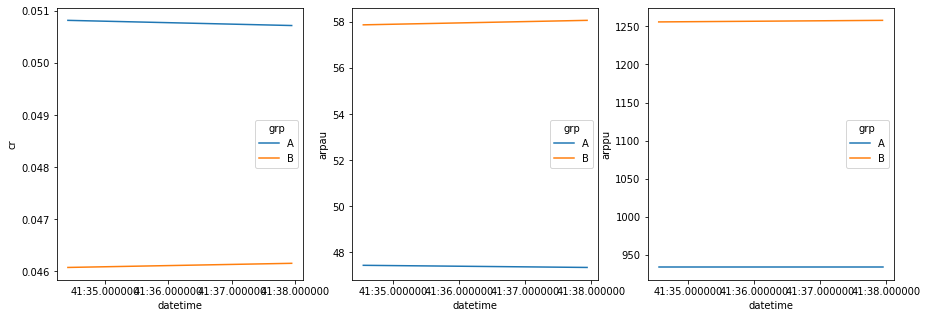

In [33]:
metric_graph(CR, ARPAU, ARPPU)